<a href="https://colab.research.google.com/github/navas017/Grupo40-Practica2/blob/main/NotebookP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1.INTRODUCCIÓN** 

El objetivo de la práctica consiste en predecir la cantidad de energía que se va a necesitar en Oklahoma con 24 horas de antelación, por medio de un modelo de predicción previamente entrenado y con sus hiper parámetros optimizados.
A lo largo del documento se encontrarán los distintos apartados en los que se busca ese modelo de predicción, divididos en procesado: de datos, dónde se toman los datos de archivos externos; el EDA, dónde se comprueban las relaciones entre los distintos datos y se crean hipótesis; modelos básicos, dónde se crean modelos básicos con y sin hiper parámetros optimizados y estos se comparan de manera gráfica; modelos avanzados, en él se llevan a cabo las mismas acciones del apartado anterior pero con modelos avanzados; modelo final, dónde se realiza la predicción utilizando el mejor modelo de entre todos los obtenidos en los apartados anteriores y conclusiones EDA, dónde se presentan los resultados obtenidos tras reducir el dataset con el estudio EDA.  


### Importación de librerías 

In [ ]:
import pandas as pd
import numpy as np
import urllib.request
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import math
import time

### Importación de datos

In [ ]:
with open('/content/drive/MyDrive/Aprendizaje Automático/Datos2/attrition_available_40.pkl', 'rb') as f:
    df = pickle.load(f)

# **2.ANÁLISIS EXPLORATORIO DE DATOS (EDA)**

En este apartado se estudia el propio conjunto de datos. En la mayoría de los casos, es conventiente realizar un análisis de este tipo pues existen atributos inútiles para la creación de modelos.

### Proporción del tipo de atributos

Seguidamente, se va a estudiar la proporción para cada tipo de atributo en el dataset. En este caso, la división se realiza entre atributos numéricos (float), ordinales (int) y categóricos (object).

Se dispone de un dataset con 4410 instancias, con 31 atributos cada una, los cuales se dividen en 21 atributos tipo float64, 2 atributos int64 y 8 objetos. En cuanto al tipo de los atributos, el dataset posee 15 atributos numéricos, 8 atributos ordinales y 8 atributos categóricos.

### Atributos eliminables

En primer lugar, se van a estudiar los atributos eliminables directamente, por su aportación nula al valor de los datos.

En primer lugar, el atributo "EmployeeID" no ofrece información relevante y es eliminable

In [ ]:
df.drop('EmployeeID', axis=1, inplace=True)

En segundo lugar, es posible borrar los atributos cuya varianza sea 0, es decir, que se mantengan costantes a lo largo de todo el dataset. Estos datos no ofrecen información extra y solo añaden tiempo de procesamiento a la creación de modelos.

In [ ]:
const_cols = []
for col in df.columns:
    if df[col].nunique() == 1:
        const_cols.append(col)
print("Columnas constantes o innecesarias:", const_cols)

df.drop(const_cols, axis=1, inplace=True)

Columnas constantes o innecesarias: ['EmployeeCount', 'Over18', 'StandardHours']


### Proporción de NaN en atributos

También se va a estudiar qué proporción de NaN existe en cada columna del dataset.

In [ ]:
nan_prop = df.isna().mean()
print(nan_prop)

hrs                        0.169388
absences                   0.194331
JobInvolvement             0.167574
PerformanceRating          0.199093
EnvironmentSatisfaction    0.222222
JobSatisfaction            0.004535
WorkLifeBalance            0.008617
Age                        0.000000
Attrition                  0.000000
BusinessTravel             0.205896
Department                 0.179138
DistanceFromHome           0.162812
Education                  0.216100
EducationField             0.204535
Gender                     0.206349
JobLevel                   0.182086
JobRole                    0.174376
MaritalStatus              0.212472
MonthlyIncome              0.180499
NumCompaniesWorked         0.172336
PercentSalaryHike          0.195692
StockOptionLevel           0.186395
TotalWorkingYears          0.175057
TrainingTimesLastYear      0.000000
YearsAtCompany             0.208844
YearsSinceLastPromotion    0.196145
YearsWithCurrManager       0.209524
dtype: float64


Como se puede observar, la proporción de **'missing values'** en la mayoría de atributos se aproxima al **20%**. En el apartado de **Procesamiento de Datos** se dará solución a este problema.

También es importante ver que la variable objetivo **'Attrition'** tiene un **0%** de **'missing values'**. Esto es importante pues cualquier fila que tuviese un NaN en esta columna debería ser eliminada.

### Tipo de problema

Como paso final de este EDA, queda comprobar qué tipo de problema va a tratarse.

Está claro debido a la índole de la variable de salida (variable categórica) que el problema es de **clasificación**. La variable **'Attrition'** es una variable **booleana**, es decir, True/False; por esto, el trabajo consiste en predecir en función del resto de atributos si el valor de **Attrition** será **Yes** (True) o **No** (False).

Conociendo el tipo de problema, es preciso estudiar si existe **debalanceo** en la variable de salida **Attrition**:

In [ ]:
prop_Y = df['Attrition'].value_counts(normalize=True)['Yes']
prop_N = df['Attrition'].value_counts(normalize=True)['No']

print(f"Proporción de Yes en Attrition: {prop_Y:.2f}")
print(f"Proporción de No en Attrition: {prop_N:.2f}")

Proporción de Yes en Attrition: 0.16
Proporción de No en Attrition: 0.84


Observando los resultados obtenidos para la proporción de **Yes** y **No** en **Attrition**, está claro que existe **desbalanceo**. Hay muchos más valores de No que de Yes en la columna. Este problema se trata de solucionar en el apartado **Procesamiento de Datos** y a la hora de crear los modelos.

# **3. PROCESAMIENTO DE DATOS**

Tomando el EDA como referencia y habiendo identificado los problemas principales con los datos del enunciado, en el **Procesamiento de datos** se dará solución a la mayoría de estos problemas.

### Relleno en variables categóricas

Para rellenar las variables categóricas, tiene sentido utilizar la **moda** de la columna para sustuir los **NaN** presentes en las columnas. Otra opción sería eliminar directamente las filas con valores NaN, pero habiendo visto que supone un **20%** de los datos (aproximadamente) de cada columna, no es una solución viable pues se perdería demasiada información relevante.

In [ ]:
# Definir diccionario de columnas con valores categóricos
mode_col = {
    'BusinessTravel': df['BusinessTravel'].mode()[0],
    'Department': df['Department'].mode()[0],
    'EducationField': df['EducationField'].mode()[0],
    'Gender': df['Gender'].mode()[0],
    'JobRole': df['JobRole'].mode()[0],
    'MaritalStatus': df['MaritalStatus'].mode()[0],
    'MaritalStatus': df['MaritalStatus'].mode()[0]    
}

# Rellenar valores faltantes con las modas por columna
df.fillna(value=mode_col, inplace=True)

### Relleno en variables numéricas

Para rellenar las variables **numéricas**, tiene sentido utilizar la **mediana** de la columna para sustituir los **NaN** presentes en la columna.

In [ ]:
# Obtener lista de columnas numéricas
num_cols = list(df.select_dtypes(include=['float64', 'int64']).columns)

# Reemplazar los valores faltantes de las columnas numéricas con la mediana
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

### Comprobación de missing values

Para comprobar que todas las columnas han quedado correctamente rellenadas, se vuelve a imprimir la proporción de valores vacíos en cada columna:

In [ ]:
nan_prop = df.isna().mean()
print(nan_prop)

hrs                        0.0
absences                   0.0
JobInvolvement             0.0
PerformanceRating          0.0
EnvironmentSatisfaction    0.0
JobSatisfaction            0.0
WorkLifeBalance            0.0
Age                        0.0
Attrition                  0.0
BusinessTravel             0.0
Department                 0.0
DistanceFromHome           0.0
Education                  0.0
EducationField             0.0
Gender                     0.0
JobLevel                   0.0
JobRole                    0.0
MaritalStatus              0.0
MonthlyIncome              0.0
NumCompaniesWorked         0.0
PercentSalaryHike          0.0
StockOptionLevel           0.0
TotalWorkingYears          0.0
TrainingTimesLastYear      0.0
YearsAtCompany             0.0
YearsSinceLastPromotion    0.0
YearsWithCurrManager       0.0
dtype: float64


Efectivamente, todos los **NaN** han sido sustituidos por valores 'coherentes' con el dataset.

### Codificación de datos categóricos

Para poder utilizar las columnas con datos categóricos es preciso realizar la técnica de **One-Hot encoding** sobre dichas columnas.

In [ ]:
# Obtener las columnas categóricas del dataframe
cat_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']

# Aplicar One-Hot Encoding
df = pd.get_dummies(df, columns=cat_cols)

### Codificación variable objetivo

La variable objetivo cuenta con valores binarios Yes/No. Para codificar dichos valores, simplemente se tomará No como 0 y Yes como 1.

In [ ]:
df["Attrition"] = df["Attrition"].replace({"No": 0, "Yes": 1})

### Conjuntos de datos

Con el dataset preparado para introducirlo en modelos, resta randomizar el orden de las filas y partirlo en dos conjuntos: train y test.

In [ ]:
# Aleatorizar el orden de las filas
df = df.sample(frac=1, random_state=100429142)

train, test = train_test_split(df, test_size=0.3)

# Conjuntos para entrenar modelos
X_train = train.drop('Attrition', axis=1)
y_train = train['Attrition']

X_test = test.drop('Attrition', axis=1)
y_test = test['Attrition']

# **4. CREACIÓN DE MODELOS**

### Preparación balanceo de clases

Como se comprobó en el **EDA**, la variable objetivo '**Attrition**' está desbalanceada. Para dar solución a esto es necesario otorgar **pesos** a cada una de las dos clases [0,1] de la variable.

Al darle **pesos** en función de su **desbalanceo**, es posible **balancear** las clases y obtener mejores resultados a la hora de entrenar el modelo.

In [ ]:
# Preparación del balanceo de clases
class_weights = compute_class_weight(class_weight='balanced', classes=[0, 1], y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

## **Entrenamiento de Modelos**

### Logistic Regression

In [ ]:
# Creamos el objeto Logistic Regression
logreg = LogisticRegression(class_weight=class_weights_dict)

# Iniciar la medición del tiempo
start_time = time.time()

# Entrenamos el modelo con los datos de entrenamiento
logreg.fit(X_train, y_train)

# Finalizar la medición del tiempo y calculo del tiempo
end_time = time.time()
lr_training_time = round((end_time - start_time) * 1000, 6)

# Predecir valores de salida con datos de prueba (test)
y_pred = logreg.predict(X_test)

# Calcular la precisión del modelo
lr_accuracy = accuracy_score(y_test, y_pred)
lr_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[728 383]
 [ 70 142]]


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Boosting

In [ ]:
# Preparar el clasificador base, en este caso un árbol de decisión
base_clf = DecisionTreeClassifier(max_depth=1, class_weight=class_weights_dict)

# Definir el clasificador AdaBoost
clf = AdaBoostClassifier(estimator=base_clf, n_estimators=200)

# Iniciar la medición del tiempo
start_time = time.time()

# Entrenar el modelo con los datos de entrenamiento
clf.fit(X_train, y_train)

# Finalizar la medición del tiempo y calculo del tiempo
end_time = time.time()
clf_training_time = round((end_time - start_time) * 1000, 6)

# Predecir valores de salida con datos de prueba (test)
y_pred = clf.predict(X_test)

# Calcular la precisión del modelo
clf_accuracy = accuracy_score(y_test, y_pred)
clf_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[883 228]
 [ 59 153]]


### XGBoost

In [ ]:
# Definir el clasificador XGBoost
clf_xgb = xgb.XGBClassifier(scale_pos_weight=5, random_state=100429142)

# Iniciar la medición del tiempo
start_time = time.time()

# Entrenar el modelo con los datos de entrenamiento
clf_xgb.fit(X_train, y_train)

# Finalizar la medición del tiempo y calculo del tiempo
end_time = time.time()
xgb_training_time = round((end_time - start_time) * 1000, 6)

# Predecir valores de salida con datos de prueba (test)
y_pred_xgb = clf_xgb.predict(X_test)

# Calcular la precisión del modelo
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_xgb)

# Calcular la matriz de confusión
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:\n", conf_matrix_xgb)

Confusion Matrix:
 [[1093   18]
 [  60  152]]


## **Comparativa de Modelos**

### Tabla de valores

En este apartado se presentan los datos obtenidos con los distintos algoritmos dispuestos en forma de tabla para un mejor entendimiento.

In [ ]:
# Crear un diccionario con los valores de MAE, RMSE y tiempo de ejecución de cada modelo
data = {'Logistic Regression': [lr_accuracy, lr_balanced_accuracy, lr_training_time],
        'AdaBoost': [clf_accuracy, clf_balanced_accuracy, clf_training_time],
        'XGBoost': [xgb_accuracy, xgb_balanced_accuracy, xgb_training_time]}

# Crear un DataFrame de pandas con los valores del diccionario y especificar las etiquetas de filas y columnas
table = pd.DataFrame(data, index=['Accuracy', 'Balanced Accuracy', 'Tiempo de entrenamiento (ms)'])

display(table)

,Logistic Regression,AdaBoost,XGBoost
Accuracy,0.657596,0.783069,0.941043
Balanced Accuracy,0.662538,0.758239,0.850390
Tiempo de entrenamiento (ms),260.627270,1283.115864,850.134611


### Comparativa de Accuracy

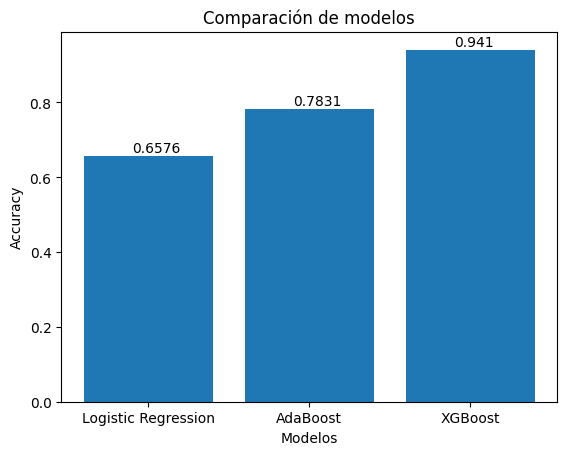

In [ ]:
# Crear una lista con los nombres de los modelos
model_names = ['Logistic Regression', 'AdaBoost', 'XGBoost']

# Crear una lista con los valores de accuracy de cada modelo
accuracy_values = [lr_accuracy, clf_accuracy, xgb_accuracy]

# Crear la figura y los ejes del gráfico
fig, ax = plt.subplots()

# Crear el gráfico de barras
ax.bar(model_names, accuracy_values)

# Agregar los valores encima de cada barra
for i, v in enumerate(accuracy_values):
    ax.text(i - 0.1, v + 0.01, str(round(v, 4)), fontsize=10)

# Agregar etiquetas y título
ax.set_xlabel('Modelos')
ax.set_ylabel('Accuracy')
ax.set_title('Comparación de modelos')

# Mostrar el gráfico
plt.show()

Se aprecia una gran diferencia entre las precisiones de los modelos entrenados. El mejor resulta ser XGBoost con una precisión ligeramente superior al 94%, puesto que su optimización de parámetros es más avanzada que el resto.

El peor modelo es Logistic Regression, con una precisión aproximada del 66%. Con precisiones tan bajas no puede considerarse como un modelo apto para la clasificación. 

### Comparativa de Balanced Accuracy

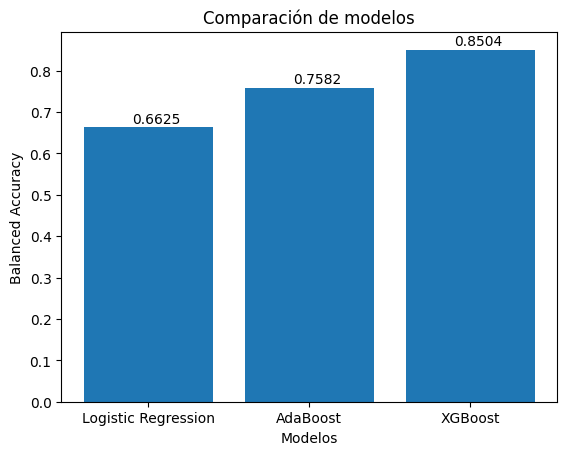

In [ ]:
# Crear una lista con los nombres de los modelos
model_names = ['Logistic Regression', 'AdaBoost', 'XGBoost']

# Crear una lista con los valores de accuracy de cada modelo
accuracy_values = [lr_balanced_accuracy, clf_balanced_accuracy, xgb_balanced_accuracy]

# Crear la figura y los ejes del gráfico
fig, ax = plt.subplots()

# Crear el gráfico de barras
ax.bar(model_names, accuracy_values)

# Agregar los valores encima de cada barra
for i, v in enumerate(accuracy_values):
    ax.text(i - 0.1, v + 0.01, str(round(v, 4)), fontsize=10)

# Agregar etiquetas y título
ax.set_xlabel('Modelos')
ax.set_ylabel('Balanced Accuracy')
ax.set_title('Comparación de modelos')

# Mostrar el gráfico
plt.show()

### Comparativa Tiempo de Entrenamiento

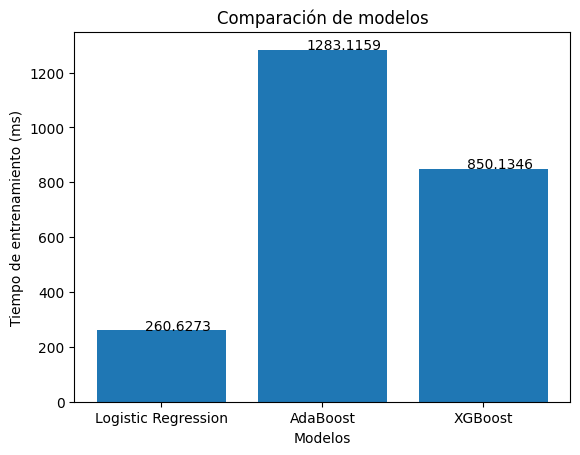

In [ ]:
# Crear una lista con los nombres de los modelos
model_names = ['Logistic Regression', 'AdaBoost', 'XGBoost']

# Crear una lista con los valores de accuracy de cada modelo
accuracy_values = [lr_training_time, clf_training_time, xgb_training_time]

# Crear la figura y los ejes del gráfico
fig, ax = plt.subplots()

# Crear el gráfico de barras
ax.bar(model_names, accuracy_values)

# Agregar los valores encima de cada barra
for i, v in enumerate(accuracy_values):
    ax.text(i - 0.1, v + 0.01, str(round(v, 4)), fontsize=10)

# Agregar etiquetas y título
ax.set_xlabel('Modelos')
ax.set_ylabel('Tiempo de entrenamiento (ms)')
ax.set_title('Comparación de modelos')

# Mostrar el gráfico
plt.show()

# **5. SELECCIÓN DE ATRIBUTOS**

Es posible utilizar métodos para limpiar aún más el dataset. Entre estos métodos se encuentra **SelectKBest**, que aplicando técnicas de **filtrado** y estudiando la **correlación** entre atributos, es capaz de determinar qué variables no aportan a la información del dataset.

In [ ]:
# Seleccionar las 10 mejores características usando la prueba chi-cuadrado
selector = SelectKBest(chi2, k=10)
new_X_train = selector.fit_transform(X_train, y_train)
new_X_test = selector.transform(X_test)

In [ ]:
# Seleccionar las 10 mejores características usando la prueba ANOVA F
selector = SelectKBest(f_classif, k=10)
X_train_new = selector.fit_transform(X_train, y_train)
X_test_new = selector.transform(X_test)

## **Entrenamiento de Modelos**

### Logistic Regression

In [ ]:
# Creamos el objeto Logistic Regression
logreg = LogisticRegression(class_weight=class_weights_dict)

# Iniciar la medición del tiempo
start_time = time.time()

# Entrenamos el modelo con los datos de entrenamiento
logreg.fit(new_X_train, y_train)

# Finalizar la medición del tiempo y calculo del tiempo
end_time = time.time()
new_lr_training_time = round((end_time - start_time) * 1000, 6)

# Predecir valores de salida con datos de prueba (test)
y_pred = logreg.predict(new_X_test)

# Calcular la precisión del modelo
new_lr_accuracy = accuracy_score(y_test, y_pred)
new_lr_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# Calcular la matriz de confusión
new_lr_conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[883 228]
 [ 59 153]]


### Boosting

In [ ]:
# Preparar el clasificador base, en este caso un árbol de decisión
base_clf = DecisionTreeClassifier(max_depth=1, class_weight=class_weights_dict)

# Definir el clasificador AdaBoost
clf = AdaBoostClassifier(estimator=base_clf, n_estimators=200)

# Iniciar la medición del tiempo
start_time = time.time()

# Entrenar el modelo con los datos de entrenamiento
clf.fit(new_X_train, y_train)

# Finalizar la medición del tiempo y calculo del tiempo
end_time = time.time()
new_clf_training_time = round((end_time - start_time) * 1000, 6)

# Predecir valores de salida con datos de prueba (test)
y_pred = clf.predict(new_X_test)

# Calcular la precisión del modelo
new_clf_accuracy = accuracy_score(y_test, y_pred)
new_clf_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# Calcular la matriz de confusión
new__clfconf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[883 228]
 [ 59 153]]


### XGBoost

In [ ]:
# Definir el clasificador XGBoost
clf_xgb = xgb.XGBClassifier(scale_pos_weight=5, random_state=100429142)

# Iniciar la medición del tiempo
start_time = time.time()

# Entrenar el modelo con los datos de entrenamiento
clf_xgb.fit(new_X_train, y_train)

# Finalizar la medición del tiempo y calculo del tiempo
end_time = time.time()
new_xgb_training_time = round((end_time - start_time) * 1000, 6)

# Predecir valores de salida con datos de prueba (test)
y_pred_xgb = clf_xgb.predict(new_X_test)

# Calcular la precisión del modelo
new_xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
new_xgb_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_xgb)

# Calcular la matriz de confusión
new_xgb_conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:\n", conf_matrix_xgb)

Confusion Matrix:
 [[1093   18]
 [  60  152]]


## **Comparativa de Modelos**

### Tabla de datos

In [ ]:
# ***************** ATRIBUTOS SIN FILTRAR
# Crear un diccionario con los valores de MAE, RMSE y tiempo de ejecución de cada modelo
data = {'Logistic Regression': [lr_accuracy, lr_balanced_accuracy, lr_training_time],
        'AdaBoost': [clf_accuracy, clf_balanced_accuracy, clf_training_time],
        'XGBoost': [xgb_accuracy, xgb_balanced_accuracy, xgb_training_time]}

# Crear un DataFrame de pandas con los valores del diccionario y especificar las etiquetas de filas y columnas
table = pd.DataFrame(data, index=['Accuracy', 'Balanced Accuracy', 'Tiempo de entrenamiento (ms)'])


# ***************** ATRIBUTOS FILTRADOS
# Crear un diccionario con los valores de MAE, RMSE y tiempo de ejecución de cada modelo
data = {'Logistic Regression': [new_lr_accuracy, new_lr_balanced_accuracy, new_lr_training_time],
        'AdaBoost': [new_clf_accuracy, new_clf_balanced_accuracy, new_clf_training_time],
        'XGBoost': [new_xgb_accuracy, new_xgb_balanced_accuracy, new_xgb_training_time]}

# Crear un DataFrame de pandas con los valores del diccionario y especificar las etiquetas de filas y columnas
new_table = pd.DataFrame(data, index=['Accuracy', 'Balanced Accuracy', 'Tiempo de entrenamiento (ms)'])

print("Tabla sin filtrado")
display(table)

print("\n")
print("Tabla con filtrado")
display(new_table)

Tabla sin filtrado


,Logistic Regression,AdaBoost,XGBoost
Accuracy,0.657596,0.783069,0.941043
Balanced Accuracy,0.662538,0.758239,0.850390
Tiempo de entrenamiento (ms),260.627270,1283.115864,850.134611




Tabla con filtrado


,Logistic Regression,AdaBoost,XGBoost
Accuracy,0.623583,0.758125,0.900227
Balanced Accuracy,0.640378,0.716669,0.801278
Tiempo de entrenamiento (ms),121.018887,1301.584721,2024.857998


### Comparativa del Accuracy

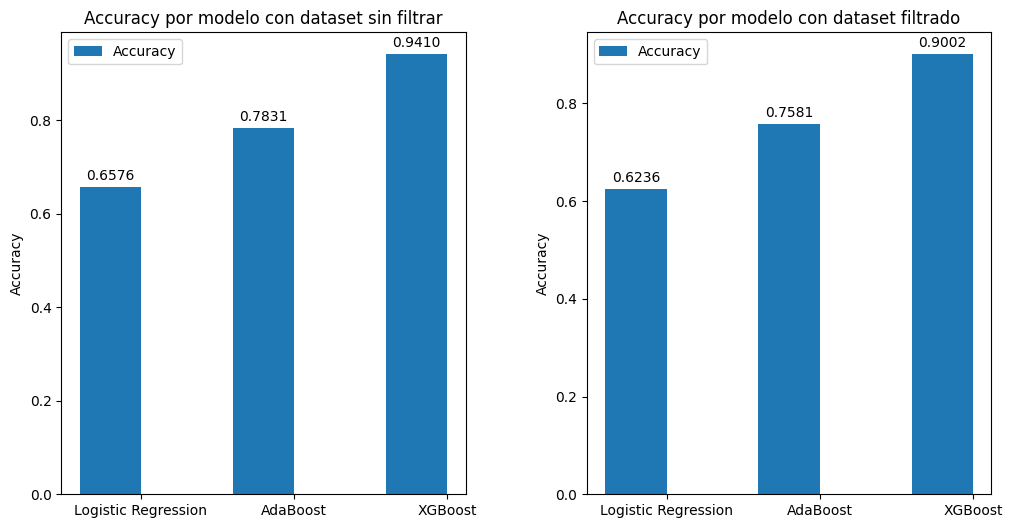

In [ ]:
# Agregar las etiquetas a las barras
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Crear los datos para los modelos
model_names = ['Logistic Regression', 'AdaBoost', 'XGBoost']
accuracy = [lr_accuracy, clf_accuracy, xgb_accuracy]
new_accuracy = [new_lr_accuracy, new_clf_accuracy, new_xgb_accuracy]

# Configurar la figura con dos conjuntos de ejes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Graficar la primera gráfica en el primer conjunto de ejes
ind = np.arange(len(model_names))
ancho = 0.4
rects1 = ax1.bar(ind - ancho/2, accuracy, ancho, label='Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy por modelo con dataset sin filtrar')
ax1.set_xticks(ind)
ax1.set_xticklabels(model_names)
ax1.legend()
autolabel(rects1, ax1)

# Graficar la segunda gráfica en el segundo conjunto de ejes
rects2 = ax2.bar(ind - ancho/2, new_accuracy, ancho, label='Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy por modelo con dataset filtrado')
ax2.set_xticks(ind)
ax2.set_xticklabels(model_names)
ax2.legend()
autolabel(rects2, ax2)

# Ajustar el margen entre las dos gráficas
fig.subplots_adjust(wspace=0.3)

# Mostrar la gráfica
plt.show()

### Comparativa del Balanced Accuracy

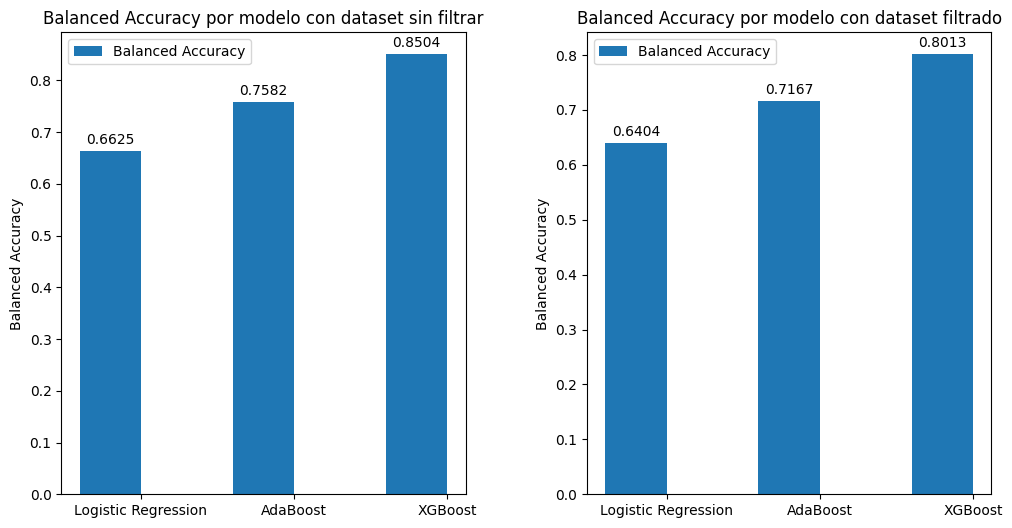

In [ ]:
# Agregar las etiquetas a las barras
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Crear los datos para los modelos
model_names = ['Logistic Regression', 'AdaBoost', 'XGBoost']
balanced_accuracy = [lr_balanced_accuracy, clf_balanced_accuracy, xgb_balanced_accuracy]
new_balanced_accuracy = [new_lr_balanced_accuracy, new_clf_balanced_accuracy, new_xgb_balanced_accuracy]

# Configurar la figura con dos conjuntos de ejes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Graficar la primera gráfica en el primer conjunto de ejes
ind = np.arange(len(model_names))
ancho = 0.4
rects1 = ax1.bar(ind - ancho/2, balanced_accuracy, ancho, label='Balanced Accuracy')
ax1.set_ylabel('Balanced Accuracy')
ax1.set_title('Balanced Accuracy por modelo con dataset sin filtrar')
ax1.set_xticks(ind)
ax1.set_xticklabels(model_names)
ax1.legend()
autolabel(rects1, ax1)

# Graficar la segunda gráfica en el segundo conjunto de ejes
rects2 = ax2.bar(ind - ancho/2, new_balanced_accuracy, ancho, label='Balanced Accuracy')
ax2.set_ylabel('Balanced Accuracy')
ax2.set_title('Balanced Accuracy por modelo con dataset filtrado')
ax2.set_xticks(ind)
ax2.set_xticklabels(model_names)
ax2.legend()
autolabel(rects2, ax2)

# Ajustar el margen entre las dos gráficas
fig.subplots_adjust(wspace=0.3)

# Mostrar la gráfica
plt.show()

### Comparativa del tiempo de entrenamiento

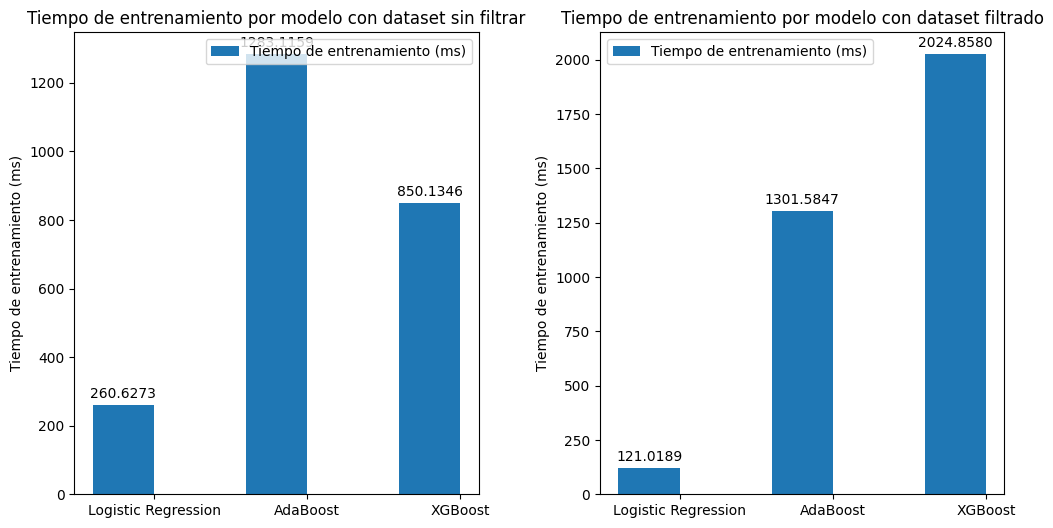

In [ ]:
# Agregar las etiquetas a las barras
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Crear los datos para los modelos
model_names = ['Logistic Regression', 'AdaBoost', 'XGBoost']
training_time = [lr_training_time, clf_training_time, xgb_training_time]
new_training_time = [new_lr_training_time, new_clf_training_time, new_xgb_training_time]

# Configurar la figura con dos conjuntos de ejes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Graficar la primera gráfica en el primer conjunto de ejes
ind = np.arange(len(model_names))
ancho = 0.4
rects1 = ax1.bar(ind - ancho/2, training_time, ancho, label='Tiempo de entrenamiento (ms)')
ax1.set_ylabel('Tiempo de entrenamiento (ms)')
ax1.set_title('Tiempo de entrenamiento por modelo con dataset sin filtrar')
ax1.set_xticks(ind)
ax1.set_xticklabels(model_names)
ax1.legend()
autolabel(rects1, ax1)

# Graficar la segunda gráfica en el segundo conjunto de ejes
rects2 = ax2.bar(ind - ancho/2, new_training_time, ancho, label='Tiempo de entrenamiento (ms)')
ax2.set_ylabel('Tiempo de entrenamiento (ms)')
ax2.set_title('Tiempo de entrenamiento por modelo con dataset filtrado')
ax2.set_xticks(ind)
ax2.set_xticklabels(model_names)
ax2.legend()
autolabel(rects2, ax2)

# Ajustar el margen entre las dos gráficas
fig.subplots_adjust(wspace=0.3)

# Mostrar la gráfica
plt.show()

# **6. MODELO FINAL Y PREDICCIONES**

# **7. CONCLUSIONES**